# CE888 Data Science and Decision Making
## Final Project
### Evolutionary Strategies for Domain Adaptation
### Office-31 Dataset
### 1702557
### Tanya Ramirez

### Important considerations
Before to start, the Office-31 dataset must be downloaded and in the same folder as this file. This dataset can be found in [here](https://people.eecs.berkeley.edu/~jhoffman/domainadapt/). 

### Observations of the dataset
##### Office-31 dataset
The following code extracts the images from the Original images folder and is defining as label the name of the category or folder (i.e. backpack, bike, bikehelmet, bookcase, etc.). 

In this case and in order to create the target set, the Amazon images were considered as the source dataset and DSLR as the target dataset.  

### Structure of the code
In a brief, this is the structure of the above code:
* In first place, the source (Amazon images) and target () data are created.
* Then, the domain adaptation model is created where the input is the data that is included in a neural network for which the ouput is features. Then,
* Finally, the previous model is applied on the source and target datasets previously defined.

In [18]:
"""
Create three different sets depending on the different domains.
"""
import os
from PIL import Image
import scipy.misc
import numpy as np
np.random.seed(1337) 

domain_amazon = "Original_images/amazon/images/"
domain_dslr = "Original_images/dslr/images/"
domain_webcam = "Original_images/webcam/images/"


In [19]:
"""
Functions to create the training, testing and validation sets.
"""


def image_list(dic):
    """
    Return the images.
    """
    image_list = []
    image_label = []
    for root, dirs, files in os.walk(dic):
        for file in files:
            if file.endswith('.jpg'):
                # print file
                temp = str(root).split('/')
                label = temp[-1]
                #label = label.split('\\')
                #label = label[-1]
                im = Image.open(root + '/' + file)
                im = np.array(im)
                im= scipy.misc.imresize(im, [84,84])
                image_list.append(im)
                image_label.append(label)
                
    return np.array(image_list), np.array(image_label)

def get_label_indices(all_label):
    """
    Return the starting index of each label.
    """
    unique_labels, counts = np.unique(all_label, return_counts = True)
    indices = list(counts)
    indices[0] = 0
    for i in range(1, len(counts)):
        indices[i] = indices[i-1] + counts[i-1]
        
    return indices

def sample_data(start_index, ending_index, training_size, testing_size):
    """
    Create sample random indices for training, testing and validation sets for each folder.
    """
    indices = list(range(start_index, ending_index ))
    training_size, testing_size = int(training_size * len(indices)), int(testing_size * len(indices))
    training_indices = np.random.choice(a = indices, size = training_size)
    remain_indices = [ i for i in indices  if i not in training_indices]
    testing_indices = np.random.choice(a = remain_indices, size = testing_size)
    valid_indices = np.asarray([i for i in remain_indices if i not in testing_indices])
    
    return (training_indices, valid_indices, testing_indices)

def split_data(label_indices,labels,train_size,test_size):
    """
    Create a training, testing and validation set for all the different categories/labels.
    """
    train_indices = []
    valid_indices = []
    testing_indices = []
    for i in range(0, len(label_indices)):
        ind = sample_data(label_indices[i], label_indices[i + 1], train_size, test_size) if i < len(dslr_label_indices) - 1 else sample_data(dslr_label_indices[i], len(labels), train_size, test_size)
        train_indices.append(ind[0])
        valid_indices.append(ind[1])
        testing_indices.append(ind[2])
    train_indices = np.concatenate(train_indices, axis = 0)
    valid_indices = np.concatenate(valid_indices, axis = 0)
    testing_indices = np.concatenate(testing_indices, axis = 0)

    np.random.shuffle(train_indices)
    np.random.shuffle(valid_indices)
    np.random.shuffle(testing_indices)
    return(train_indices, valid_indices, testing_indices)

In [20]:
amazonImages, amazonLabels = image_list(domain_amazon)
dslrImages, dslrLabels = image_list(domain_dslr)
webcamImages, webcamLabels = image_list(domain_webcam)

dslr_label_indices =  get_label_indices(dslrLabels)
amazon_label_indices = get_label_indices(amazonLabels)
webcam_label_indices = get_label_indices(webcamLabels)

dslrTraining_indices, dslrValid_indices, dslrTest_indices = split_data(dslr_label_indices, dslrLabels, 0.3, 0.6)
amazonTraining_indices, amazonValid_indices, amazonTest_indices =  split_data(amazon_label_indices, amazonLabels, 0.6, 0.35)
webcamTraining_indices, webcamValid_indices, webcamTest_indices = split_data(webcam_label_indices, webcamLabels, 0.5, 0.4)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [22]:
"""
Create training, testing and validation for each domain.
"""
amazon_tr_X, amazon_tr_Y = amazonImages[amazonTraining_indices], amazonLabels[amazonTraining_indices]
amazon_val_X, amazon_val_Y =  amazonImages[amazonTraining_indices], amazonLabels[amazonTraining_indices]
#amazonTestX, amazonTestY = amazonImages[amazonTraining_indices], amazonLabels[amazonTraining_indices]

dslr_tr_X, dslr_tr_Y = dslrImages[dslrTraining_indices], dslrLabels[dslrTraining_indices]
dslr_val_X, dslr_val_Y = dslrImages[dslrValid_indices], dslrLabels[dslrValid_indices]
#dslrTestX, dslrTestY = dslrImages[dslrTest_indices], dslrLabels[dslrTest_indices]

webcam_tr_X, webcam_tr_Y = webcamImages[webcamTraining_indices], webcamLabels[webcamTraining_indices]
webcam_val_X, webcam_val_Y = webcamImages[webcamValid_indices], webcamLabels[webcamValid_indices]
#webcamTestX, webcamTestY = webcamImages[webcamTest_indices], webcamLabels[webcamTest_indices]


In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer

import numpy as np
import pylab
import seaborn as sns
import pandas as pd

from keras_helper import NNWeightHelper
from snes import SNES

In [24]:
""""
Parameters for the SNES
"""
# Number of the different sets of weights ask() should return for evaluation
POPULATION_SIZE = 10
# Number of times we will loop over ask()/tell() - Generations
GENERATIONS = 35 #35 generations is a good result

In [25]:
"""
Functions to use for the creation of the model. 
"""
def train_classifier(model, x, y):
    x_features = model.predict(x)
    clf = RandomForestClassifier(n_estimators = 5) # Parameter to tune: number of estimators
    clf.fit(x_features, y)   
    #y_pred = clf.predict(x_features)
    return clf #, y_pred

def predict_classifier(clf, x):
    x_features = model.predict(x)
    y = clf.predict(x_features)
    return y

def score_snes(label_accuracy, domain_accuracy):
    score_snes = 0.45*label_accuracy + 0.55*domain_accuracy # Parameter to tune: weights of the score
    return score_snes


## First experiment
### Source domain is Amazon dataset and target domain is DSRL dataset 

In [26]:
"""
Define source and target domain for the first experiment.
"""
source = [(amazon_tr_X, amazon_tr_Y), (amazon_val_X, amazon_val_Y)]
target = [(dslr_tr_X, dslr_tr_Y), (dslr_val_X, dslr_val_Y)]

In [27]:
"""
Create neural network to train the random forest.
"""
input_shape = amazonImages.shape[1:]
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape,strides=(4,4)))
model.add(MaxPooling2D())
model.add(Conv2D(48, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(8, activation = 'relu')) # Parameter to tune: features for the model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 21, 21, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 48)          13872     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 48)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 6152      
Total params: 20,920
Trainable params: 20,920
Non-trainable params: 0
_________________________________________________________________


In [28]:
"""
Separate from source and target in X (images) and Y (labels).
"""
# Source domain
source_tr_X = np.asarray(source[0][0])
source_tr_Y = np.asarray(source[0][1])
        
source_val_X = np.asarray(source[1][0])
source_val_Y = np.asarray(source[1][1])

# Target domain
target_tr_X = np.asarray(target[0][0])
target_tr_Y = np.asarray(target[0][1])
        
target_val_X = np.asarray(target[1][0])
target_val_Y = np.asarray(target[1][1])

# Combined dataset for domain classifier
combined_tr_X = np.concatenate((source_tr_X, target_tr_X), axis = 0)
combined_tr_Y = np.concatenate((np.zeros(source_tr_X.shape[0]), np.ones(target_tr_X.shape[0])), axis = 0)

combined_val_X = np.concatenate((source_val_X, target_val_X), axis = 0)
combined_val_Y = np.concatenate((np.zeros(source_val_X.shape[0]), np.ones(target_val_X.shape[0])), axis = 0)

Non-trained accuracy for label classifier is 0.9434 and for the domain classifier is 0.9365
Total weights to evolve: 20920
Step 1.0 : 0.9769042968750001 Best: 0.9769042968750001 10
Generation  1
Best model: Label accuracy of 0.9785, domain accuracy of 0.9756 and overall score of 0.9769
Step 2.0 : 0.9791503906250001 Best: 0.9791503906250001 10
Generation  2
Best model: Label accuracy of 0.9775, domain accuracy of 0.9805 and overall score of 0.9792
Step 3.0 : 0.9744140625000001 Best: 0.9791503906250001 10
Generation  3
Best model: Label accuracy of 0.9766, domain accuracy of 0.9727 and overall score of 0.9744
Step 4.0 : 0.97431640625 Best: 0.9791503906250001 10
Generation  4
Best model: Label accuracy of 0.9775, domain accuracy of 0.9717 and overall score of 0.9743
Step 5.0 : 0.9789062500000001 Best: 0.9791503906250001 10
Generation  5
Best model: Label accuracy of 0.9854, domain accuracy of 0.9736 and overall score of 0.9789
Step 6.0 : 0.98115234375 Best: 0.98115234375 10
Generation  6


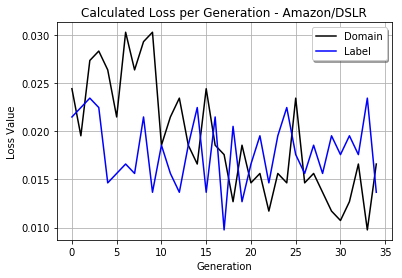

In [29]:
# For training of domain classifier 
random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = 1024)
combined_domain_tr_X = combined_tr_X[random_domainTrain_indices]
combined_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

# For validation of domain classifier
random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = 1024)
combined_domain_val_X = combined_val_X[random_domainValid_indices]
combined_domain_val_Y = combined_val_Y[random_domainValid_indices]

# For label validation
source_validation_indices = np.random.choice(a = list((range(source_val_X.shape[0]))), size = 1024)
val_X = source_val_X[source_validation_indices]
val_Y = source_val_Y[source_validation_indices]

"""
Non-trained accuracy for label and domain prediction.
"""
label_clf = train_classifier(model, source_tr_X, source_tr_Y)
label_pred = predict_classifier(label_clf, val_X)
label_accuracy = accuracy_score(val_Y, label_pred)

domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
domain_pred = predict_classifier(domain_clf, combined_domain_val_X)
domain_accuracy = accuracy_score(combined_domain_val_Y, domain_pred)

print('Non-trained accuracy for label classifier is %0.4f and for the domain classifier is %0.4f'
      %(label_accuracy, domain_accuracy))


weight_modifier = NNWeightHelper(model)
weights = weight_modifier.get_weights()
print('Total weights to evolve:', len(weights))

snes = SNES(weights, 1, POPULATION_SIZE)
        
start = timer()
        
loss_score = []
loss_domain = []
loss_label = []

for i in range(GENERATIONS):
    new_weights = snes.ask()

    scores = []
    domain_accuracies = []
    label_accuracies = []

    """
    Retrain the RF with the new weights
    """
    for w in new_weights:
        weight_modifier.set_weights(w)
                
        # Train the label classifier: using only source domain
        label_clf = train_classifier(model, source_tr_X, source_tr_Y)
        label_predictions = predict_classifier(label_clf, val_X)
        label_accuracy = accuracy_score(val_Y, label_predictions)

        # Train the domain classifier in a mixed domain dataset
        domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
        domain_predictions = predict_classifier(domain_clf, combined_domain_val_X)
        domain_accuracy = accuracy_score(combined_domain_val_Y, domain_predictions)

        # Accuracy from domain classifier, label classifier and the score(fitness) for SNES
        scores.append(score_snes(label_accuracy, domain_accuracy))
        domain_accuracies.append(domain_accuracy)
        label_accuracies.append(label_accuracy)

        
    snes.tell(new_weights, scores)
    new_model = np.argmax(scores)
    print("Generation ", i + 1)
    print("Best model: Label accuracy of %0.4f, domain accuracy of %0.4f and overall score of %0.4f" 
                 %(label_accuracies[new_model], domain_accuracies[new_model], scores[new_model]))
                        
    l_score = 1 - scores[new_model]
    l_domain = 1 - domain_accuracies[new_model]
    l_label = 1 - label_accuracies[new_model]

    loss_score.append(l_score)
    loss_domain.append(l_domain)
    loss_label.append(l_label)
    
end = timer()

print(end - start)

weight_modifier.set_weights(snes.center)

label_clf = train_classifier(model, source_tr_X, source_tr_Y)

random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = combined_tr_X.shape[0]) 
all_domain_tr_X = combined_tr_X[random_domainTrain_indices]
all_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

domain_clf = train_classifier(model, all_domain_tr_X, all_domain_tr_Y)

random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = combined_val_X.shape[0])
all_domain_testX = combined_val_X[random_domainValid_indices]
all_domain_testY = combined_val_Y[random_domainValid_indices]

source_label_predictions = predict_classifier(label_clf, source_val_X)
target_label_predictions = predict_classifier(label_clf, target_tr_X)
domain_predictions = predict_classifier(domain_clf, all_domain_testX)

# Evaluation in both datasets for label classifier and evaluation in a mix dataset for domain classifiers
print('Accuracy of prediction of labels in source validation dataset is %0.4f'% 
      (accuracy_score(source_val_Y, source_label_predictions)))
print('Accuracy of prediction of labels in target validation dataset is %0.4f'%
      (accuracy_score(target_tr_Y, target_label_predictions)))
print('Accuracy of prediction of domain in both validation datasets is %0.4f'%
      (accuracy_score(all_domain_testY, domain_predictions)))
        
# Plot of the losses in each generation
fig = pylab.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_xlabel("Generation")
ax.set_ylabel("Loss Value")
ax.set_title("Calculated Loss per Generation - Amazon/DSLR")

#ax.plot(loss_score, 'r', label = 'Score')
ax.plot(loss_domain, 'k', label = 'Domain')
ax.plot(loss_label, 'b', label = 'Label')
legend = ax.legend(loc = 'upper right', shadow = True)
#plt.savefig('mnistm_loss_generation.png')

pylab.show()

## Second experiment
### Source domain is DSLR dataset and target domain is Webcam dataset

In [48]:
"""
Define source and target domain for the second experiment.
"""
source = [(dslr_tr_X, dslr_tr_Y), (dslr_val_X, dslr_val_Y)]
target = [(webcam_tr_X, webcam_tr_Y), (webcam_val_X, webcam_val_Y)]

In [49]:
"""
Create neural network to train the random forest.
"""
input_shape = dslrImages.shape[1:]
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape, strides=(4,4)))
model.add(MaxPooling2D())
model.add(Conv2D(48, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(8, activation = 'relu')) # Parameter to tune: features for the model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 21, 21, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 48)          13872     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 6152      
Total params: 20,920
Trainable params: 20,920
Non-trainable params: 0
_________________________________________________________________


In [50]:
"""
Separate from source and target in X (images) and Y (labels).
"""
# Source domain
source_tr_X = np.asarray(source[0][0])
source_tr_Y = np.asarray(source[0][1])
        
source_val_X = np.asarray(source[1][0])
source_val_Y = np.asarray(source[1][1])

# Target domain
target_tr_X = np.asarray(target[0][0])
target_tr_Y = np.asarray(target[0][1])
        
target_val_X = np.asarray(target[1][0])
target_val_Y = np.asarray(target[1][1])

# Combined dataset for domain classifier
combined_tr_X = np.concatenate((source_tr_X, target_tr_X), axis = 0)
combined_tr_Y = np.concatenate((np.zeros(source_tr_X.shape[0]), np.ones(target_tr_X.shape[0])), axis = 0)

combined_val_X = np.concatenate((source_val_X, target_val_X), axis = 0)
combined_val_Y = np.concatenate((np.zeros(source_val_X.shape[0]), np.ones(target_val_X.shape[0])), axis = 0)

Non-trained accuracy for label classifier is 0.1338 and for the domain classifier is 0.8447
Total weights to evolve: 20920
Step 1.0 : 0.5475097656250001 Best: 0.5475097656250001 10
Generation  1
Best model: Label accuracy of 0.1484, domain accuracy of 0.8740 and overall score of 0.5475
Step 2.0 : 0.5807128906250001 Best: 0.5807128906250001 10
Generation  2
Best model: Label accuracy of 0.1924, domain accuracy of 0.8984 and overall score of 0.5807
Step 3.0 : 0.5538574218750001 Best: 0.5807128906250001 10
Generation  3
Best model: Label accuracy of 0.1709, domain accuracy of 0.8672 and overall score of 0.5539
Step 4.0 : 0.5742187500000001 Best: 0.5807128906250001 10
Generation  4
Best model: Label accuracy of 0.1768, domain accuracy of 0.8994 and overall score of 0.5742
Step 5.0 : 0.570654296875 Best: 0.5807128906250001 10
Generation  5
Best model: Label accuracy of 0.1855, domain accuracy of 0.8857 and overall score of 0.5707
Step 6.0 : 0.5779296875000001 Best: 0.5807128906250001 10
Gen

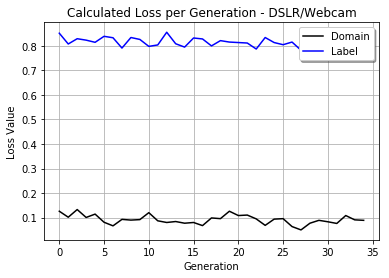

In [51]:
# For training of domain classifier 
random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = 1024)
combined_domain_tr_X = combined_tr_X[random_domainTrain_indices]
combined_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

# For validation of domain classifier
random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = 1024)
combined_domain_val_X = combined_val_X[random_domainValid_indices]
combined_domain_val_Y = combined_val_Y[random_domainValid_indices]

# For label validation
source_validation_indices = np.random.choice(a = list((range(source_val_X.shape[0]))), size = 1024)
val_X = source_val_X[source_validation_indices]
val_Y = source_val_Y[source_validation_indices]

"""
Non-trained accuracy for label and domain prediction.
"""
label_clf = train_classifier(model, source_tr_X, source_tr_Y)
label_pred = predict_classifier(label_clf, val_X)
label_accuracy = accuracy_score(val_Y, label_pred)

domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
domain_pred = predict_classifier(domain_clf, combined_domain_val_X)
domain_accuracy = accuracy_score(combined_domain_val_Y, domain_pred)

print('Non-trained accuracy for label classifier is %0.4f and for the domain classifier is %0.4f'
      %(label_accuracy, domain_accuracy))


weight_modifier = NNWeightHelper(model)
weights = weight_modifier.get_weights()
print('Total weights to evolve:', len(weights))

snes = SNES(weights, 1, POPULATION_SIZE)
        
start = timer()
        
loss_score = []
loss_domain = []
loss_label = []

for i in range(GENERATIONS):
    new_weights = snes.ask()

    scores = []
    domain_accuracies = []
    label_accuracies = []

    """
    Retrain the RF with the new weights
    """
    for w in new_weights:
        weight_modifier.set_weights(w)
                
        # Train the label classifier using only source domain
        label_clf = train_classifier(model, source_tr_X, source_tr_Y)
        label_predictions = predict_classifier(label_clf, val_X)
        label_accuracy = accuracy_score(val_Y, label_predictions)

        # Train the domain classifier in a mixed domain dataset
        domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
        domain_predictions = predict_classifier(domain_clf, combined_domain_val_X)
        domain_accuracy = accuracy_score(combined_domain_val_Y, domain_predictions)

        # Accuracy from domain classifier, label classifier and the score(fitness) for SNES
        scores.append(score_snes(label_accuracy, domain_accuracy))
        domain_accuracies.append(domain_accuracy)
        label_accuracies.append(label_accuracy)

        
    snes.tell(new_weights, scores)
    new_model = np.argmax(scores)
    print("Generation ", i + 1)
    print("Best model: Label accuracy of %0.4f, domain accuracy of %0.4f and overall score of %0.4f" 
                 %(label_accuracies[new_model], domain_accuracies[new_model], scores[new_model]))
                        
    l_score = 1 - scores[new_model]
    l_domain = 1 - domain_accuracies[new_model]
    l_label = 1 - label_accuracies[new_model]

    loss_score.append(l_score)
    loss_domain.append(l_domain)
    loss_label.append(l_label)
    
end = timer()

print(end - start)

weight_modifier.set_weights(snes.center)

label_clf = train_classifier(model, source_tr_X, source_tr_Y)

random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = combined_tr_X.shape[0]) 
all_domain_tr_X = combined_tr_X[random_domainTrain_indices]
all_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

domain_clf = train_classifier(model, all_domain_tr_X, all_domain_tr_Y)

random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = combined_val_X.shape[0])
all_domain_testX = combined_val_X[random_domainValid_indices]
all_domain_testY = combined_val_Y[random_domainValid_indices]

source_label_predictions = predict_classifier(label_clf, source_val_X)
target_label_predictions = predict_classifier(label_clf, target_tr_X)
domain_predictions = predict_classifier(domain_clf, all_domain_testX)

# Evaluation in both datasets for label classifier and evaluation in a mix dataset for domain classifiers
print('Accuracy of prediction of labels in source validation dataset is %0.4f'% 
      (accuracy_score(source_val_Y, source_label_predictions)))
print('Accuracy of prediction of labels in target validation dataset is %0.4f'%
      (accuracy_score(target_tr_Y, target_label_predictions)))
print('Accuracy of prediction of domain in both validation datasets is %0.4f'%
      (accuracy_score(all_domain_testY, domain_predictions)))
        
# Plot of the losses in each generation
fig = pylab.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_xlabel("Generation")
ax.set_ylabel("Loss Value")
ax.set_title("Calculated Loss per Generation - DSLR/Webcam")

#ax.plot(loss_score, 'r', label = 'Score')
ax.plot(loss_domain, 'k', label = 'Domain')
ax.plot(loss_label, 'b', label = 'Label')
legend = ax.legend(loc = 'upper right', shadow = True)
#plt.savefig('mnistm_loss_generation.png')

pylab.show()

## Third experiment
### Source domain is Webcam dataset and target domain is DSLR dataset 

In [52]:
"""
Define source and target domain for the third experiment.
"""
source = [(webcam_tr_X, webcam_tr_Y), (webcam_val_X, webcam_val_Y)]
target = [(dslr_tr_X, dslr_tr_Y), (dslr_val_X, dslr_val_Y)]

In [53]:
"""
Separate from source and target in X (images) and Y (labels).
"""
# Source domain
source_tr_X = np.asarray(source[0][0])
source_tr_Y = np.asarray(source[0][1])
        
source_val_X = np.asarray(source[1][0])
source_val_Y = np.asarray(source[1][1])

# Target domain
target_tr_X = np.asarray(target[0][0])
target_tr_Y = np.asarray(target[0][1])
        
target_val_X = np.asarray(target[1][0])
target_val_Y = np.asarray(target[1][1])

# Combined dataset for domain classifier
combined_tr_X = np.concatenate((source_tr_X, target_tr_X), axis = 0)
combined_tr_Y = np.concatenate((np.zeros(source_tr_X.shape[0]), np.ones(target_tr_X.shape[0])), axis = 0)

combined_val_X = np.concatenate((source_val_X, target_val_X), axis = 0)
combined_val_Y = np.concatenate((np.zeros(source_val_X.shape[0]), np.ones(target_val_X.shape[0])), axis = 0)

In [54]:
"""
Create neural network to train the random forest.
"""
input_shape = webcamImages.shape[1:]
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape,strides=(4,4)))
model.add(MaxPooling2D())
model.add(Conv2D(48, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(8, activation = 'relu')) # Parameter to tune: features for the model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 21, 21, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 48)          13872     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 6152      
Total params: 20,920
Trainable params: 20,920
Non-trainable params: 0
_________________________________________________________________


Non-trained accuracy for label classifier is 0.2754 and for the domain classifier is 0.7266
Total weights to evolve: 20920
Step 1.0 : 0.65546875 Best: 0.65546875 10
Generation  1
Best model: Label accuracy of 0.3525, domain accuracy of 0.9033 and overall score of 0.6555
Step 2.0 : 0.615576171875 Best: 0.65546875 10
Generation  2
Best model: Label accuracy of 0.3486, domain accuracy of 0.8340 and overall score of 0.6156
Step 3.0 : 0.6669921875 Best: 0.6669921875 10
Generation  3
Best model: Label accuracy of 0.3877, domain accuracy of 0.8955 and overall score of 0.6670
Step 4.0 : 0.663525390625 Best: 0.6669921875 10
Generation  4
Best model: Label accuracy of 0.3848, domain accuracy of 0.8916 and overall score of 0.6635
Step 5.0 : 0.6546875000000001 Best: 0.6669921875 10
Generation  5
Best model: Label accuracy of 0.3496, domain accuracy of 0.9043 and overall score of 0.6547
Step 6.0 : 0.63427734375 Best: 0.6669921875 10
Generation  6
Best model: Label accuracy of 0.3496, domain accurac

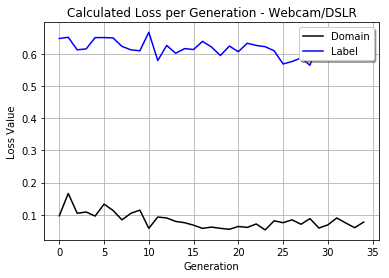

In [55]:
# For training of domain classifier 
random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = 1024)
combined_domain_tr_X = combined_tr_X[random_domainTrain_indices]
combined_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

# For validation of domain classifier
random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = 1024)
combined_domain_val_X = combined_val_X[random_domainValid_indices]
combined_domain_val_Y = combined_val_Y[random_domainValid_indices]

# For label validation
source_validation_indices = np.random.choice(a = list((range(source_val_X.shape[0]))), size = 1024)
val_X = source_val_X[source_validation_indices]
val_Y = source_val_Y[source_validation_indices]

"""
Non-trained accuracy for label and domain prediction.
"""
label_clf = train_classifier(model, source_tr_X, source_tr_Y)
label_pred = predict_classifier(label_clf, val_X)
label_accuracy = accuracy_score(val_Y, label_pred)

domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
domain_pred = predict_classifier(domain_clf, combined_domain_val_X)
domain_accuracy = accuracy_score(combined_domain_val_Y, domain_pred)

print('Non-trained accuracy for label classifier is %0.4f and for the domain classifier is %0.4f'
      %(label_accuracy, domain_accuracy))


weight_modifier = NNWeightHelper(model)
weights = weight_modifier.get_weights()
print('Total weights to evolve:', len(weights))

snes = SNES(weights, 1, POPULATION_SIZE)
        
start = timer()
        
loss_score = []
loss_domain = []
loss_label = []

for i in range(GENERATIONS):
    new_weights = snes.ask()

    scores = []
    domain_accuracies = []
    label_accuracies = []

    """
    Retrain the RF with the new weights
    """
    for w in new_weights:
        weight_modifier.set_weights(w)
                
        # Train the label classifier: using only source domain
        label_clf = train_classifier(model, source_tr_X, source_tr_Y)
        label_predictions = predict_classifier(label_clf, val_X)
        label_accuracy = accuracy_score(val_Y, label_predictions)

        # Train the domain classifier in a mixed domain dataset
        domain_clf = train_classifier(model, combined_domain_tr_X, combined_domain_tr_Y)
        domain_predictions = predict_classifier(domain_clf, combined_domain_val_X)
        domain_accuracy = accuracy_score(combined_domain_val_Y, domain_predictions)

        # Accuracy from domain classifier, label classifier and the score(fitness) for SNES
        scores.append(score_snes(label_accuracy, domain_accuracy))
        domain_accuracies.append(domain_accuracy)
        label_accuracies.append(label_accuracy)

        
    snes.tell(new_weights, scores)
    new_model = np.argmax(scores)
    print("Generation ", i + 1)
    print("Best model: Label accuracy of %0.4f, domain accuracy of %0.4f and overall score of %0.4f" 
                 %(label_accuracies[new_model], domain_accuracies[new_model], scores[new_model]))
                        
    l_score = 1 - scores[new_model]
    l_domain = 1 - domain_accuracies[new_model]
    l_label = 1 - label_accuracies[new_model]

    loss_score.append(l_score)
    loss_domain.append(l_domain)
    loss_label.append(l_label)
    
end = timer()

print(end - start)

weight_modifier.set_weights(snes.center)

label_clf = train_classifier(model, source_tr_X, source_tr_Y)

random_domainTrain_indices = np.random.choice(a = list(range(combined_tr_X.shape[0])), size = combined_tr_X.shape[0]) 
all_domain_tr_X = combined_tr_X[random_domainTrain_indices]
all_domain_tr_Y = combined_tr_Y[random_domainTrain_indices]

domain_clf = train_classifier(model, all_domain_tr_X, all_domain_tr_Y)

random_domainValid_indices = np.random.choice(a = list(range(combined_val_X.shape[0])), size = combined_val_X.shape[0])
all_domain_testX = combined_val_X[random_domainValid_indices]
all_domain_testY = combined_val_Y[random_domainValid_indices]

source_label_predictions = predict_classifier(label_clf, source_val_X)
target_label_predictions = predict_classifier(label_clf, target_tr_X)
domain_predictions = predict_classifier(domain_clf, all_domain_testX)

# Evaluation in both datasets for label classifier and evaluation in a mix dataset for domain classifiers
print('Accuracy of prediction of labels in source validation dataset is %0.4f'% 
      (accuracy_score(source_val_Y, source_label_predictions)))
print('Accuracy of prediction of labels in target validation dataset is %0.4f'%
      (accuracy_score(target_tr_Y, target_label_predictions)))
print('Accuracy of prediction of domain in both validation datasets is %0.4f'%
      (accuracy_score(all_domain_testY, domain_predictions)))
        
# Plot of the losses in each generation
fig = pylab.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_xlabel("Generation")
ax.set_ylabel("Loss Value")
ax.set_title("Calculated Loss per Generation - Webcam/DSLR")

#ax.plot(loss_score, 'r', label = 'Score')
ax.plot(loss_domain, 'k', label = 'Domain')
ax.plot(loss_label, 'b', label = 'Label')
legend = ax.legend(loc = 'upper right', shadow = True)
#plt.savefig('mnistm_loss_generation.png')

pylab.show()